## 0. Configs

In [1]:
# HF_MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"
HF_MODEL_NAME = "prajjwal1/bert-tiny"
MODELS_FOLDER = './models'
MODEL_SAVE_NAME = 'bert-tiny'
MODEL_LOAD_NAME = None
USE_WANDB = True

RS = 42  # Random state
TRAIN_FRACTION = 0.9
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
EPOCHS = 5

## 1. Data loading

### 1.1. Json to Dataframe

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm

In [3]:
# Read the raw json
url = 'training_set.json'
with open(url, 'r') as file:
    raw = json.load(file)['data']
data = []
for topic in raw:
    for paragraph in topic['paragraphs']:
        for question in paragraph['qas']:
            assert len(question['answers']) == 1
            answer = question['answers'][0]
            data.append((
                question['id'],
                topic['title'],
                paragraph['context'],
                question['question'],
                answer['text'],
                answer['answer_start'],
                answer['answer_start'] + len(answer['text']),
            ))
dataset = pd.DataFrame(data,
                       columns=('id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'answer_end'))
dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126


In [4]:
dataset: pd.DataFrame = dataset.apply(pd.to_numeric, errors='ignore').convert_dtypes()
# NOTE: stripping makes the test in the next cell fail
# dataset['context'] = dataset['context'].str.strip()
# dataset['question'] = dataset['question'].str.strip()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            87599 non-null  string
 1   title         87599 non-null  string
 2   context       87599 non-null  string
 3   question      87599 non-null  string
 4   answer_text   87599 non-null  string
 5   answer_start  87599 non-null  Int64 
 6   answer_end    87599 non-null  Int64 
dtypes: Int64(2), string(5)
memory usage: 4.8 MB


In [5]:
# Simple tests
for _, q in dataset.iterrows():
    assert q['answer_text'] == q['context'][q['answer_start']:q['answer_end']]
print("TEST PASSED: answer-text == context[start:end]")

TEST PASSED: answer-text == context[start:end]


### 1.2. Data exploration

99% percentile of context word count: 282


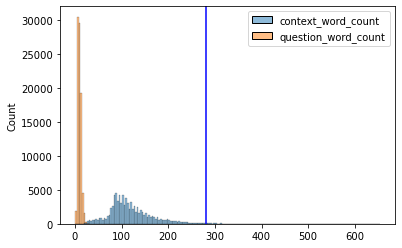

In [6]:
import seaborn as sns

sentence_lengths = pd.DataFrame(
    dataset[['context', 'question']].applymap(str.split).applymap(len).to_numpy(),
    columns=['context_word_count', 'question_word_count'],
)
quantile99 = int(np.quantile(sentence_lengths['context_word_count'], 0.99))

ax = sns.histplot(sentence_lengths)
ax.axvline(x=quantile99, color='b')
print(f"99% percentile of context word count: {quantile99}")
# Note: after tokenization the numbers may differ but not dramatically

### 1.3. Tokenization

In [7]:
import torch
from transformers import AutoTokenizer, PreTrainedTokenizerFast

tokenizer: PreTrainedTokenizerFast = AutoTokenizer.from_pretrained(HF_MODEL_NAME)

In [8]:
s = "Test sequence"
t = tokenizer("Test sequence")
print(s)
print(tokenizer.decode(t['input_ids']))

Test sequence
[CLS] test sequence [SEP]


In [9]:
# Tokenize the context and questions
tok = []
log_answers_not_found = 0

for _, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    # Standard tokenizer
    t = tokenizer(
        row['question'],
        row['context'],
        max_length=512,
        truncation='only_second',
        padding='max_length',
        return_offsets_mapping=True,
    )

    offset_mapping = np.array(t['offset_mapping'])
    token_type_ids = np.array(t['token_type_ids'])

    # Get where the answer is located, by looking at tokens that satisfy:
    #  - they start after the answer
    #  - they end before the answer
    #  - they are part of the context
    answer_context = (
            (offset_mapping[:, 0] >= row['answer_start']) *
            (offset_mapping[:, 1] <= row['answer_end']) *
            token_type_ids.astype(bool)
    )

    # Note: for now truncation is not handled
    # Debug printing
    # print(row['answer_text'])
    # print(tokenizer.decode(np.array(t['input_ids'])[answer_context]))
    # print(answer_context)

    # Get the first and last index of the answer context
    answer_tok_idx = np.argwhere(answer_context).ravel()
    isp = iep = 0
    if answer_tok_idx.size == 0:
        log_answers_not_found += 1
    else:
        isp = answer_tok_idx[0]
        iep = answer_tok_idx[-1]
        assert isp <= iep

    tok.append({
        'input_ids': torch.tensor(t['input_ids']),
        'token_type_ids': torch.tensor(token_type_ids),
        'attention_mask': torch.tensor(t['attention_mask']),
        'start_positions': torch.tensor(isp),
        'end_positions': torch.tensor(iep),
        'offset_mapping': offset_mapping,
    })

print(f"Answers not found: {log_answers_not_found}")
# To handle this, we need to do handle larger inputs by slicing or ignore it

  0%|          | 0/87599 [00:00<?, ?it/s]

Answers not found: 171


In [10]:
tokenized_dataset = pd.concat((dataset, pd.DataFrame(tok)), axis=1)
tokenized_dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end,input_ids,token_type_ids,attention_mask,start_positions,end_positions,offset_mapping
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541,"[tensor(101), tensor(2000), tensor(3183), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(130),tensor(137),"[[0, 0], [0, 2], [3, 7], [8, 11], [12, 15], [1..."
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213,"[tensor(101), tensor(2054), tensor(2003), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(52),tensor(56),"[[0, 0], [0, 4], [5, 7], [8, 10], [11, 16], [1..."
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296,"[tensor(101), tensor(1996), tensor(13546), ten...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(81),tensor(83),"[[0, 0], [0, 3], [4, 12], [13, 15], [16, 19], ..."
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420,"[tensor(101), tensor(2054), tensor(2003), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(95),tensor(101),"[[0, 0], [0, 4], [5, 7], [8, 11], [12, 14], [1..."
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126,"[tensor(101), tensor(2054), tensor(7719), tens...","[tensor(0, dtype=torch.int32), tensor(0, dtype...","[tensor(1), tensor(1), tensor(1), tensor(1), t...",tensor(33),tensor(39),"[[0, 0], [0, 4], [5, 9], [10, 12], [13, 16], [..."


In [11]:
# Test how the questions+context are tokenized and decoded
q = tokenized_dataset.iloc[0]
s = q['question'] + q['context']
t = q['input_ids']
print(s)
print()
print(tokenizer.decode(t))

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.

[CLS] to whom did the virgin mary allegedly appear in 1858 in lourdes france? [SEP] architecturally, the school has a catholic character. atop the main building's gold dome is a golden statue of the virgin mary. immediately in front

### 1.4. Train-Val split

In [12]:
# Get the questions' titles and shuffle them
titles = tokenized_dataset['title'].unique()
shuffled_titles = pd.Series(titles).sample(frac=1, random_state=RS)

# Get the Question Indices grouped by title
qi_by_titles = tokenized_dataset.groupby(['title']).indices
training_indices = []
min_train_len = int(len(tokenized_dataset) * TRAIN_FRACTION)

# Add questions until enough are present
for title in shuffled_titles:
    training_indices += qi_by_titles[title].tolist()
    if len(training_indices) >= min_train_len:
        break

# Create the datasets using the indices
ds_train = tokenized_dataset.iloc[training_indices]
ds_val = tokenized_dataset.drop(ds_train.index)

print(f"Training samples: {len(ds_train)}")
print(f"Validation samples: {len(ds_val)}")
print(f"Actual fraction: {len(ds_train) / len(tokenized_dataset):.4f}")

Training samples: 78964
Validation samples: 8635
Actual fraction: 0.9014


### 1.5. Converting the data for PyTorch

In [13]:
from torch.utils.data import DataLoader, Dataset


class QADataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        return {
            'input_ids': item['input_ids'],
            'token_type_ids': item['token_type_ids'],
            'attention_mask': item['attention_mask'],
            'start_positions': item['start_positions'],
            'end_positions': item['end_positions']
        }

In [14]:
train_loader = DataLoader(QADataset(ds_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(QADataset(ds_val), batch_size=BATCH_SIZE, shuffle=False)

## 2. Training the model

### 2.1. Loading the model
[docs](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForQuestionAnswering)

In [15]:
from transformers import BertForQuestionAnswering
from torchinfo import torchinfo

model: BertForQuestionAnswering = BertForQuestionAnswering.from_pretrained(HF_MODEL_NAME)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
BertForQuestionAnswering                                --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              3,906,816
│    │    └─Embedding: 3-2                              65,536
│    │    └─Embedding: 3-3                              256
│    │    └─LayerNorm: 3-4                              256
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             396,544
├─Linear: 1-2                                           258
Total params: 4,369,666
Trainable params: 4,369,666
Non-trainable params: 0

### 2.2. Metrics

In [17]:
import evaluate


def calc_f1(answer_text, answer_text_pred):
    f1s = []
    for text, pred in zip(answer_text, answer_text_pred):
        f1s.append(evaluate.compute_f1(text, pred))
    return pd.Series(f1s, name='f1')
    # return evaluate.compute_f1(answer_text, answer_text_pred)


def calc_em_str(answer_text, answer_text_pred):
    # Use string comparison
    return (answer_text == answer_text_pred).astype(int).rename('em')


def calc_em_tensor(answer_start, answer_end, answer_start_pred, answer_end_pred):
    # Use TOKEN index comparison
    return torch.logical_and(
        answer_start == answer_start_pred,
        answer_end == answer_end_pred,
    ).float()

### 2.3. Validation / Evaluation function

In [18]:
def evaluate_model(model, loader: DataLoader, return_frame=False, display_bar=False):
    _loader = tqdm(loader) if display_bar else loader

    # Store the answers' TOK indices
    answer_start_tok= []
    answer_end_tok=[]


    # Get outputs from the model
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in _loader:
            args = dict(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=batch['token_type_ids'].to(device),
            )
            outputs = model(**args)

            # Get the answers' TOK indices
            answer_start_tok += torch.argmax(outputs['start_logits'], dim=1).tolist()
            answer_end_tok += torch.argmax(outputs['end_logits'], dim=1).tolist()

    # Convert the TOK indices into TEXT using the context
    df = loader.dataset.df.reset_index()
    answer_text_pred = []
    for idx, row in df.iterrows():
        om = row['offset_mapping']
        tst, ten = answer_start_tok[idx], answer_end_tok[idx]  # Tok start, tok end
        cst, cen = om[tst, 0], om[ten, 1]  # Char start, Char end
        answer_text_pred.append(row['context'][cst:cen])
    answer_text_pred = pd.Series(answer_text_pred)

    # Compute the metrics
    f1s = calc_f1(df['answer_text'], answer_text_pred)
    ems = calc_em_str(df['answer_text'], answer_text_pred)

    out = {'f1_mean': sum(f1s)/len(f1s), 'em_mean': sum(ems)/len(ems)}
    if return_frame:
        out['dataframe'] = pd.concat([df, pd.DataFrame({'answer_text_pred':answer_text_pred, 'f1': f1s, 'em':ems})], axis=1)
    return out

### 2.4 Wandb Integration & Model save-load functions

In [19]:
%env WANDB_SILENT=True

env: WANDB_SILENT=True


In [20]:
import wandb

wandb_params = dict(
    project="NLP-Question-Answering",
    entity="frantoman",
    reinit=True,
    group=HF_MODEL_NAME,
    config=dict(
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        optimizer='adam',
        model_name=HF_MODEL_NAME,
    )
)

run = None
if USE_WANDB:
    run = wandb.init(project="NLP-Question-Answering", entity="frantoman")
    print(f"Logging run {run.name} at {run.url}")

Logging run quiet-morning-4 at https://wandb.ai/frantoman/NLP-Question-Answering/runs/2995rh9v


In [21]:
from datetime import datetime
from pathlib import Path

Path(MODELS_FOLDER).mkdir(parents=True, exist_ok=True)
save_filepath = f"{MODELS_FOLDER}/{MODEL_SAVE_NAME}_{datetime.today().strftime('%m%d')}.pt"

def save_model(model, filepath=save_filepath):
    torch.save(model.state_dict(), filepath)
    # print(f'Model saved in {filepath}')

def load_model(model, filepath=save_filepath):
    model.load_state_dict(torch.load(filepath))
    print(f'Loaded model at {filepath}')

### 2.5. Training loop

In [22]:
# Initialize stuff
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
torch.cuda.empty_cache()
model.train()
best_f1 = 0  # Used for determining when the model performance over the epochs is degrading

# Iterate through the epochs
for epoch in range(1, EPOCHS + 1):
    # Epoch's history
    ep_loss = []
    ep_em = []

    train_iter = tqdm(train_loader, desc=f'Epoch {epoch}', leave=True)

    # Training
    for train_batch in train_iter:
        # Extract the model arguments from the batch, and do a forward-pass
        opt.zero_grad()
        args = dict(
            input_ids=train_batch['input_ids'].to(device),
            attention_mask=train_batch['attention_mask'].to(device),
            start_positions=train_batch['start_positions'].to(device),
            end_positions=train_batch['end_positions'].to(device),
            token_type_ids=train_batch['token_type_ids'].to(device),
        )
        outputs = model(**args)

        # Get the starting and end token indices
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        # Log the Loss and Exact Matches for the batch
        loss = outputs['loss']
        em = calc_em_tensor(args['start_positions'], args['end_positions'], start_pred, end_pred)
        em_mean = em.mean().item()
        ep_loss.append(loss.item())
        ep_em.append(em_mean)

        # Update the progress bar
        train_iter.set_postfix(loss=sum(ep_loss[-50:]) / len(ep_loss[-50:]),
                               em=sum(ep_em[-50:]) / len(ep_em[-50:]))

        # Backwards-pass
        loss.backward()
        opt.step()

    # Validation & Saving
    val_out = evaluate_model(model, val_loader)
    f1 = val_out['f1_mean']
    if f1 > best_f1:
        best_f1 = f1
        save_model(model)

    # End of epoch
    train_iter.close()
    if USE_WANDB:
        run.log(dict(
            epoch=epoch,
            em=sum(ep_em) / len(ep_em),
            loss=sum(ep_loss) / len(ep_loss),
            val_em=val_out['em_mean'],
            val_f1=val_out['f1_mean'],
        ))

Epoch 1:   0%|          | 0/4936 [00:00<?, ?it/s]

Model saved in ./models/bert-tiny_0131.pt


Epoch 2:   0%|          | 0/4936 [00:00<?, ?it/s]

Model saved in ./models/bert-tiny_0131.pt


Epoch 3:   0%|          | 0/4936 [00:00<?, ?it/s]

Model saved in ./models/bert-tiny_0131.pt


Epoch 4:   0%|          | 0/4936 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/4936 [00:00<?, ?it/s]

### 2.6. Uploading artifacts to Wandb

In [24]:
# Upload the fine-tuned model
model_save_artifact = wandb.Artifact('model', type='model')
model_save_artifact.add_file(save_filepath)
run.log_artifact(model_save_artifact)

# Upload some (100) validation outputs of the model
load_model(model)
out = evaluate_model(model, DataLoader(QADataset(ds_val.iloc[:100])), return_frame=True)
df = out['dataframe'][['question', 'context', 'answer_text', 'answer_text_pred', 'f1', 'em']]
out_table = wandb.Table(data=df, columns=df.columns)
result_artifact = wandb.Artifact('validation_output', type='result')
result_artifact.add(out_table, 'validation_output')
run.log_artifact(result_artifact)

Loaded model at ./models/bert-tiny_0131.pt


## 3. Evaluation

In [ ]:
def output_to_file(data: pd.DataFrame):
    raw_out = {}
    data.apply(lambda row: raw_out.update({row['id']: row['answer_text_pred']}), axis=1)
    with open('predictions.txt', 'w+') as fout:
        fout.write(json.dumps(raw_out))

In [ ]:
# %run evaluate.py "training_set.json" "predictions.txt"